In [9]:
from rdkit.Chem import AllChem, Draw, DataStructs
import pandas as pd
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from tqdm.notebook import tqdm

In [10]:
rt_and_smi_df = pd.read_csv('./rt_and_smi.csv')
smi1_df = pd.read_csv('./smiles-lifetime.csv')
rt_and_smi_df
# smi1_df

,rt_smarts,smi2
0,[c:1].[CH3:2]Br>>[c:1][CH3:2],CBr
1,[c:1].[Br:2]Br>>[c:1][Br:2],BrBr
2,[c:1].[Cl:2]Cl>>[c:1][Cl:2],ClCl
3,[c:1].[I:2]I>>[c:1][I:2],II
4,[c:1].[CH:2]#[N:3]>>[c:1][C:2]#[N:3],C#N


In [11]:
smi1_df['Filename'] = (smi1_df['Filename'].str.replace(r'^ps', 'p', regex=True)
                       .str.replace(r'^acceptor', 'a', regex=True).str.replace('.sdf', '', regex=False))
smi1_df

,molecule_id,Filename,lifetime,SMILES
0,1,a1,0.577167,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...
1,2,a2,0.660066,c1ccc2cc3cc4ccccc4cc3cc2c1
2,3,a3,0.591716,O=C(O)c1c2ccccc2cc2cc3ccccc3cc12
3,4,a4,46.709764,C(#Cc1c2ccccc2c(C#Cc2ccccc2)c2cc3ccccc3cc12)c1...
4,5,a5,0.000543,c1ccc2cc3c(-c4ccc(-c5ccc(-c6c7ccccc7cc7cc8cccc...
...,...,...,...,...
358,246,p246,13.090719,CC1(C)c2ccccc2Nc2ccccc21
359,247,p247,0.271518,c1ccc(C2(c3ccccc3)c3ccccc3Nc3ccccc32)cc1
360,248,p248,1.617338,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2-c2ccccc21
361,249,p249,1.699813,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Oc2ccccc21


In [12]:
rt_and_smi_df

,rt_smarts,smi2
0,[c:1].[CH3:2]Br>>[c:1][CH3:2],CBr
1,[c:1].[Br:2]Br>>[c:1][Br:2],BrBr
2,[c:1].[Cl:2]Cl>>[c:1][Cl:2],ClCl
3,[c:1].[I:2]I>>[c:1][I:2],II
4,[c:1].[CH:2]#[N:3]>>[c:1][C:2]#[N:3],C#N


In [13]:
# 例子，请替换成你的分子
smi1_list = smi1_df['SMILES'].values
smi1_names = smi1_df['Filename'].values
# ['c1ccccc1', 'c1c(CCC)cccc1']

In [14]:
smi1_list[0], smi1_names[0]

('c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c4ccccc4)c23)cc1',
 'a1')

In [15]:
# 分子预处理函数
def preprocess_molecule(mol):
    try:
        if mol is None:
            return None
        mol.UpdatePropertyCache(strict=False)  # 更新分子属性缓存
        Chem.GetSSSR(mol)  # 初始化环系统信息
        return mol
    except Exception as e:
        print(f"Error preprocessing molecule: {e}")
        return None

In [16]:
# 主要代码区域
all_products = {'smi1': [], 'smi2': [], 'product': [], 'pro_from_smi1_name': [],'similarity': []}
for smi1,fn in tqdm(zip(smi1_list,smi1_names), desc="Processing SMILES 1", total=len(smi1_list), ncols=100):
    mol1 = AllChem.MolFromSmiles(smi1)
    fp1 = MACCSkeys.GenMACCSKeys(mol1)  # 计算指纹
    for _, row in rt_and_smi_df.iterrows():
        rt_sma = row['rt_smarts']
        smi2 = row['smi2']
        rt = AllChem.ReactionFromSmarts(rt_sma)
        mol2 = AllChem.MolFromSmiles(smi2)
        products = rt.RunReactants((mol1, mol2))
        for product in products:
            mol_pro = preprocess_molecule(product[0]) 
            fp_product = MACCSkeys.GenMACCSKeys(mol_pro)  # 计算指纹
            similarity = DataStructs.TanimotoSimilarity(fp1, fp_product)
            all_products['smi1'].append(smi1)
            all_products['smi2'].append(smi2)
            all_products['product'].append(AllChem.MolToSmiles(product[0]))
            all_products['pro_from_smi1_name'].append(f'{fn}') 
            all_products['similarity'].append(similarity) 

all_products_df = pd.DataFrame(all_products)

Processing SMILES 1:   0%|                                                  | 0/363 [00:00<?, ?it/s]

In [18]:
all_products_df[all_products_df['pro_from_smi1_name']=='p114']

,smi1,smi2,product,pro_from_smi1_name,similarity
36552,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1(Cl)cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3c...,p114,0.896552
36553,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([n...,p114,0.962963
36554,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1cc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([nH...,p114,0.962963
36555,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([n...,p114,0.962963
36556,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1(Cl)cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3c...,p114,0.896552
...,...,...,...,...,...
36867,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,C#N,N#Cc1(Cl)cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c...,p114,0.896552
36868,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,C#N,N#Cc12ccc([nH]1)c(-c1c(Cl)cccc1Cl)c1nc(c(-c3c(...,p114,0.866667
36869,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,C#N,N#Cc1cc2[nH]c1c(-c1c(Cl)cccc1Cl)c1nc(c(-c3c(Cl...,p114,0.962963
36870,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,C#N,N#Cc1cc2[nH]c1c(-c1c(Cl)cccc1Cl)c1nc(c(-c3c(Cl...,p114,0.962963


In [19]:
# 去重
cleaned_all_products_df = all_products_df.drop_duplicates(subset=['product'], keep='first')

# 去除非法分子
cleaned_all_products_df = cleaned_all_products_df.loc[cleaned_all_products_df['product'].map(lambda x: AllChem.MolFromSmiles(x) is not None)].reset_index()

cleaned_all_products_df

[23:12:13] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 29 30 31 32 33 34 35 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 22 23 24 25 26 27 28 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12 13 14 15 22 23 30 31 32 33 34 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 29 30 31 32 33 34 35 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 22 23 24 25 26 27 28 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12 13 14 15 22 23 30 31 32 33 34 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 29 30 31 32 33 34 35 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 22 23 24 25 26 27 28 35 36
[23:12:13] Can

[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16 17 18 19 20
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16 17 18 19 20
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16 17 18 19 20
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 22 23 24 25 26 27
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 15 16 17 18 19 20 21
[23:12:13] Can't kekulize mol.  Unkekulized ato

[23:12:13] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 37 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 37 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 38 39 40 41 42 43
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 23 24 25 26 27 28 29
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 17 18 19 20 21 22
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 12 13 14 15 16 17 18
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 17 18 19 20 21 22
[23:12:13] Can

[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 37 38 39 40 41 42 43 44 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 43 44 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 44 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 44 45 46 47 48 49
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 37 38 39 40 41 42 43
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16 17 18 19 20
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 44 45 

[23:12:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 15 16 17 18 23 24 25
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 22 23 24 25 30 31
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 19 20 21 22 23 24 25
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 45 46
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 20 21 22 45 46
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 39 40 41 42 43 44
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 38 39 40 41 42
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 40 41 42 43 44
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 39 40 41 42 43 44
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[23:12:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 45 46
[23:12:13] Can't kekulize mol.  Unkekulized atoms:

[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 20 21 22 23 26 27 28 29 30 31 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 28 29 30
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 21 22 23 24 25 26 27 28 29 30 31 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 28 29 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 22 23 24 25 26 27 28 29 30 31 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 20 21 22 23 26 27 28 29 30 31 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 28 29 30
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 21 22 23 24 25 26 27 28 29 30 31 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 28 29 32
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11

[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 17
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 1

[23:12:14] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 20
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 21
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 21
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 12 13 14 15 16
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 14 15 16 17 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 12 13 14 15 16
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 14 15 16 17 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 12 13 14 15 16
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 14 15 16 17 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 12 13 14 15 16
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 14 15 16 17 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 4

[23:12:14] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 17
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 3 10 11
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 22 23 24 29 30
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 12 19 20
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 10 12 21
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 10 11 18
[23:12:14] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 28
[23:12:14] Can't kekulize mol.  Unkekulized atoms

[23:12:15] Can't kekulize mol.  Unkekulized atoms: 22 23 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 38 39 40 42 43
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 36 37 38 42 43
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 26 27 30 31 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 24 35 36
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 22 24 32
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 26 27 30 31 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 22 23 34
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 38 39 40 42 43
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 36 37 38 42 43
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 34
[23:12:15] Can't kekulize mol.  Un

[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 23 24 25 26 27 28 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 21 22 25 26 27 28 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 28 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 4 5 6
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 29
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 19 20 21 22 

[23:12:15] Can't kekulize mol.  Unkekulized atoms: 8 9 10 39 40
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 15 17 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 12 13 16
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 12 13 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 12 13 15
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 42 44 45
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 39 41 43
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 39 40 42
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 40 41
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 8 9 10 40 41
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 16 18 20
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 14 15 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 14 15 20
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[23:12:15] Can

[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[23:12:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5

[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 14 15 16 21 22 23 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 15 16 21 22 23 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 21 22 23 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 15 22 23 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 15 20 21 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 14 15 16 20 21 22 23 24 25 27 28 29
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 15 16 20 21 22 23 24 25 27 28 29
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 20 21 22 23 24 25 27 28 29
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 15 22 23 24 25 26 28 29 30
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 13 14 15 19 20 24 25 26 28 29 30
[23:12:16] Can't kek

[23:12:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 29 30 31 33 46 47 48 49 62 63 64 65
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 27 28 29 33 46 47 48 49 62 63 64 65
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 27 28 29 30 46 47 48 49 62 63 64 65
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 35 37 38 39 44
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 33 34 36 41 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 44
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 38
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 27 28 29 30 32 47 48 49 62 63 64 65
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 26
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 15 16 18 23 24
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 17 19 20 21 26
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28 29 30 31 33 46 47 48 49 62 63 64 65
[23:12:16] Can't kekulize mo

[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 17 18 19 20 21 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 17 18 19 20 21 23 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 17 18 19 20 21 23 37
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 12 13 14 15 16 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 10 11 12 13 14 15 16 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12 13 14 15 16 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 13 14 15 16 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 15 16 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 18 19 20 21 22 24 38 40
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 19 20 21 22 24 38 40
[23:12:16] Can'

[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 20 21 22 23 24 26 27 28 29 30 33
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 17 21 22 23 24 26 27 28 29 30 33
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 17 18 20 21 22 23 24 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 18 20 21 22 23 24 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 20 21 22 23 24 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 17 21 22 23 24 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 17 19 20 23 24 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 17 19 20 21 22 27 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 17 19 20 21 22 23 40 42
[23:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14 15 16 17 19 20 21 22 23 26 42
[23:12:16]

[23:12:17] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 10 11 13 14 15 16 17 18 19 38
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 10 11 13 14 15 16 17 18 19 30
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 18 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 17 18 21 22 24 40 42
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 12 13 14 15 16 17 18 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 13 14 15 16 17 18 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12 15 16 17 18 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12 13 14 17 18 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12 13 14 15 16 20 21 22 25 36 43
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12 13 14 15 16 17 21 22 25 36 43
[23:12:17] Can't kekulize mol.

[23:12:17] Can't kekulize mol.  Unkekulized atoms: 24 25 26
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 21 23
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 22 24 31
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 22 24
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 21 31
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 26 27 28
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 24 25 26
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 21 23
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 22 24 31
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 22 24
[23:12:17] Can't kekulize mol.  Unkekuli

[23:12:17] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 19 20
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 8 9 12 13 14 15 16 17 18 19 20
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16 17 18
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 16 17 18 19 20
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16 17 18
[23:12:17] Explicit valence for atom # 21 C, 6, is greater than permitted
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 16 17 18 19 20 21 22 23 24
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 22 23 24
[23:12:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8

,index,smi1,smi2,product,pro_from_smi1_name,similarity
0,0,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,a1,0.888889
1,1,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c...,a1,0.888889
2,2,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccccc1-c1c2ccccc2c(-c2ccccc2)c2c(-c3ccccc3)...,a1,0.727273
3,6,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,a1,0.888889
4,7,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c4...,a1,0.888889
...,...,...,...,...,...,...
9522,51053,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Sc2ccccc21,C#N,N#Cc1cccc2c1Nc1ccccc1C21c2ccccc2Sc2ccccc21,p250,0.884615
9523,51061,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Sc2ccccc21,C#N,N#Cc1cccc2c1C1(c3ccccc3Nc3ccccc31)c1ccccc1S2,p250,0.920000
9524,51062,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Sc2ccccc21,C#N,N#Cc1ccc2c(c1)C1(c3ccccc3Nc3ccccc31)c1ccccc1S2,p250,0.920000
9525,51063,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Sc2ccccc21,C#N,N#Cc1ccc2c(c1)Sc1ccccc1C21c2ccccc2Nc2ccccc21,p250,0.920000


In [22]:
filter_df = cleaned_all_products_df[cleaned_all_products_df['pro_from_smi1_name']=='p114']
filter_df

,index,smi1,smi2,product,pro_from_smi1_name,similarity
7562,36553,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([n...,p114,0.962963
7563,36554,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1cc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([nH...,p114,0.962963
7564,36569,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1cc2[nH]c1c(-c1c(Cl)cccc1Cl)c1nc(c(-c3c(Cl)c...,p114,0.962963
7565,36594,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,BrBr,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,p114,0.962963
7566,36596,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,BrBr,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,p114,0.962963
7567,36626,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,BrBr,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3cc(B...,p114,0.962963
7568,36674,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,ClCl,Clc1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([...,p114,1.000000
7569,36676,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,ClCl,Clc1cc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([n...,p114,1.000000
7570,36706,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,ClCl,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3cc(C...,p114,1.000000
7571,36754,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,II,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,p114,0.962963


In [27]:
len(set(filter_df['smi1'])),len(set(filter_df['product'])),len(filter_df['product'])

(1, 15, 15)

In [28]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

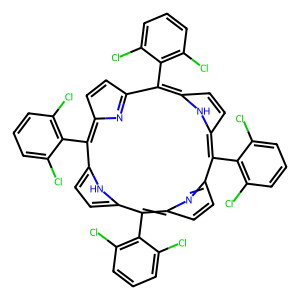

In [34]:
mol = AllChem.MolFromSmiles(filter_df['smi1'].values[0])
Draw.MolToImage(mol)

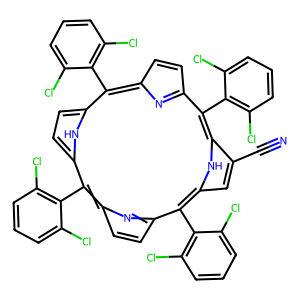

In [50]:
mol = AllChem.MolFromSmiles(filter_df['product'].values[14])
Draw.MolToImage(mol)

### 截止到目前为止，pro_from_smi1_name对应的smi1正确

In [20]:
# 保存
cleaned_all_products_df.to_csv('cleaned_all_products.csv', index=False)

In [10]:
min_similarity_`indices = cleaned_all_products_df.nsmallest(10, 'similarity').index
min_similarity_indices

Int64Index([3050, 3053, 3056, 206, 207, 210, 211, 214, 215, 305], dtype='int64')

In [11]:
min_similarity_indices = cleaned_all_products_df.nsmallest(10, 'similarity').index
min_similarity_df = cleaned_all_products_df.iloc[min_similarity_indices]
min_similarity_df

,index,smi1,smi2,product,pro_from_smi1_name,similarity
3050,15264,N#Cc1ccccc1,BrBr,N#Cc1ccccc1Br,a91,0.454545
3053,15276,N#Cc1ccccc1,ClCl,N#Cc1ccccc1Cl,a91,0.454545
3056,15288,N#Cc1ccccc1,II,N#Cc1ccccc1I,a91,0.454545
206,1270,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,BrBr,Brc1ccccc1-c1ccc(-c2ccccc2)cc1,a6,0.500000
207,1276,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,BrBr,Brc1cc(-c2ccccc2)ccc1-c1ccccc1,a6,0.500000
210,1306,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,ClCl,Clc1ccccc1-c1ccc(-c2ccccc2)cc1,a6,0.500000
211,1312,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,ClCl,Clc1cc(-c2ccccc2)ccc1-c1ccccc1,a6,0.500000
214,1342,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,II,Ic1ccccc1-c1ccc(-c2ccccc2)cc1,a6,0.500000
215,1348,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,II,Ic1cc(-c2ccccc2)ccc1-c1ccccc1,a6,0.500000
305,1708,c1ccc(-c2ccc(-c3ccc(-c4ccccc4)cc3)cc2)cc1,BrBr,Brc1ccccc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,a11,0.500000


In [12]:
min_similarity_df['smi1']

3050                                  N#Cc1ccccc1
3053                                  N#Cc1ccccc1
3056                                  N#Cc1ccccc1
206                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
207                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
210                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
211                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
214                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
215                c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
305     c1ccc(-c2ccc(-c3ccc(-c4ccccc4)cc3)cc2)cc1
Name: smi1, dtype: object

In [13]:
min_similarity_df['smi1'].values[-1]

'c1ccc(-c2ccc(-c3ccc(-c4ccccc4)cc3)cc2)cc1'

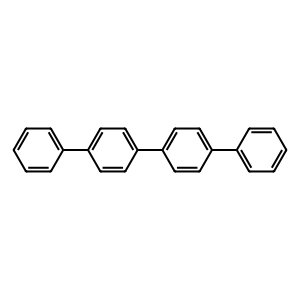

In [14]:
# 画一个看看
Draw.MolToImage(AllChem.MolFromSmiles(min_similarity_df['smi1'].values[-1]))

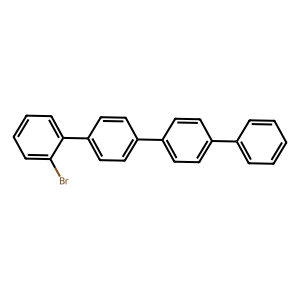

In [15]:
i=9
Draw.MolToImage(AllChem.MolFromSmiles(min_similarity_df['product'].values[i]))

In [ ]:
cleaned_all_products_df

### 找到没有生成新分子的smi1

In [16]:
len(set(cleaned_all_products_df['smi1']))

339

In [72]:
# 获取cleaned_all_products_df['smi1']中的所有SMILES（作为set）
smiles_in_cleaned_all = set(cleaned_all_products_df['smi1'])

# 获取smi1_df['SMILES']中的所有SMILES（作为set）
smiles_in_smi1_df = set(smi1_df['SMILES'])

# 找出缺少的24个SMILES
missing_smiles = smiles_in_smi1_df - smiles_in_cleaned_all

# 根据缺少的SMILES获取对应的索引
missing_smiles_indices = smi1_df[smi1_df['SMILES'].isin(missing_smiles)].index

missing_smiles_indices

Int64Index([84, 85, 177, 184, 185, 186, 190, 205, 225, 237, 238, 240, 281,
            331],
           dtype='int64')

In [73]:
missing_smiles 

{'C1=CC=CCC=C1',
 'C1=CCCC=C1',
 'C=CC1=C(C)/C2=C/c3[nH]c(c(C)c3C=C)/C=C3\\N=C(/C=C4\\C/C(=C\\C1=N2)C(C)=C4CCC(=O)O)C(CCC(=O)O)=C3C',
 'C=CC1=CC2=NC1CC1=N/C(=C\\C3=C(C)C4=C(O)C/C(=C5/N/C(=C\\2)[C@@H](C)[C@@H]5CCC(=O)O)C4=N3)C(CC)=C1C',
 'CC(=O)C(=O)O',
 'CC(=O)C(C)=O',
 'CC1=C(I)C(C)=[N+]2C1=Cc1c(C)c(I)c(C)n1[B-]2(F)F',
 'CCC1=C(C)C2=C(C3=C4C(C)=C(CC)C(C)=[N+]4[B-](F)(F)n4c(C)c(CC)c(C)c43)c3c(C)c(CC)c(C)n3[B-](F)(F)[N+]2=C1C',
 'CCCCCCOC(=O)CCC(=O)CN',
 'COC(=O)CCC(=O)CN',
 'NCC(=O)CCC(=O)O',
 'O=C(O)C1C2C=CC(C2)C1(C(=O)O)[N+](=O)[O-]',
 'O=CC(=O)O'}

In [74]:
miss_smi1_in_pro_smi = smi1_df.iloc[missing_smiles_indices]
miss_smi1_in_pro_smi

,molecule_id,Filename,lifetime,SMILES
84,89,a89,100.908174,C1=CCCC=C1
85,90,a90,24.408103,C1=CC=CCC=C1
177,1,p1,0.009525,CC(=O)C(C)=O
184,8,p8,0.175162,O=C(O)C1C2C=CC(C2)C1(C(=O)O)[N+](=O)[O-]
185,9,p9,0.008050,CC(=O)C(=O)O
186,10,p10,0.002702,O=CC(=O)O
190,15,p15,22.421525,C=CC1=CC2=NC1CC1=N/C(=C\C3=C(C)C4=C(O)C/C(=C5/...
205,33,p33,0.001990,CC1=C(I)C(C)=[N+]2C1=Cc1c(C)c(I)c(C)n1[B-]2(F)F
225,53,p53,1.339047,CCC1=C(C)C2=C(C3=C4C(C)=C(CC)C(C)=[N+]4[B-](F)...
237,74,p74,0.002229,NCC(=O)CCC(=O)O


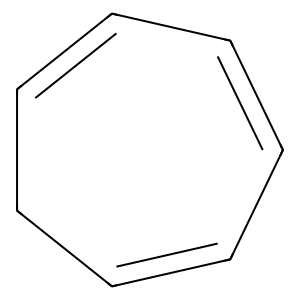

In [75]:
# 画一个看看
Draw.MolToImage(AllChem.MolFromSmiles(miss_smi1_in_pro_smi['SMILES'].values[1]))

In [76]:
# 保存
miss_smi1_in_pro_smi.to_csv('miss_smi1_in_pro_smi.csv', index=False)